# BLIP: blip experiments

In [7]:
import sys
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    img_url = 'https://images.pexels.com/photos/2040747/pexels-photo-2040747.jpeg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image, raw_image

Image captioning with blip

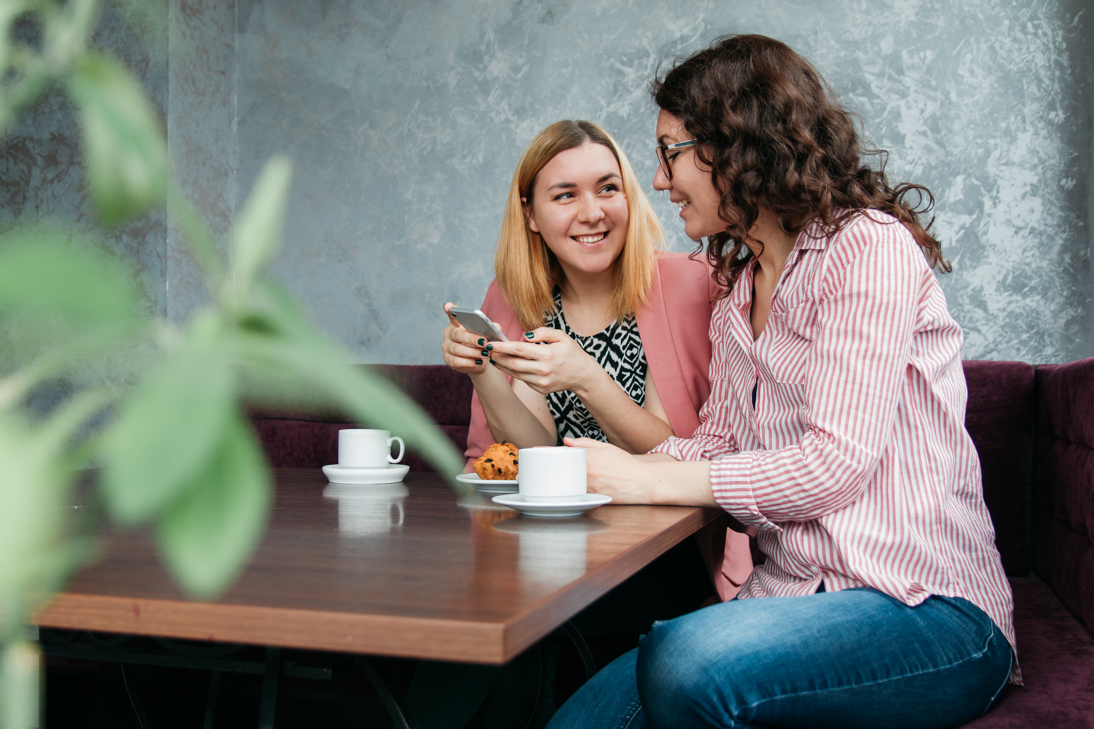

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
time:  2.3761019706726074
caption: two women sitting at a table
Text
['Two women sitting on the table watching the smartphone', 'Two women watching the smartphone', 't']
Label probs: [[7.45045424e-01 1.52318865e-01 1.02635466e-01 2.98217827e-07]]


In [39]:
from models.blip import blip_decoder
import time
import torch
import clip
from PIL import Image


image_size = 384
image, raw_image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    start = time.time()
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    print('time: ',time.time()-start)
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    caption = str(caption[0])
    print('caption: '+caption)

# Path: CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
# Load the model
model, preprocess = clip.load("ViT-B/32", device=device)

# Preprocess an image
image = preprocess(raw_image).unsqueeze(0).to(device)
# Preprocess a text
sent = ["Two women sitting on the table watching the smartphone", "Two women watching the smartphone", caption, "A dog watching the tv"]
text = clip.tokenize(sent).to(device)

# Compute logits
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print('Text')
print(["Two women sitting on the table watching the smartphone", "Two women watching the smartphone", caption[0]])
''' Observation:
the evidence shows that the encoding of really accurate caption 
get the highest probability of the correct label (image).
'''
print("Label probs:", probs) 


In [41]:
# metrics to mesure the distance between the tokenized caption
import numpy as np
import torch

""" I think that with those metrics we can mesure the distance the 
    distances between the encoded caption and the target label.

    Encoding the metrics as a vector I can easily identify with 
    a simple linear layer a try to find the best weights for weighting 
    each metric. Maybe I think that there are metrics that are more
    important than others. Specifically I think that the score in output
    score identifies the best box.

"""

def euclidean_distance(u, v):
    """Computes the euclidean distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: euclidean distance between the two sets of items
    """
    return torch.sqrt(torch.sum((u - v) ** 2))

def cosine_similarity(u, v):
    """Computes the cosine similarity between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:    
        float: cosine similarity between the two sets of items

    """
    return torch.dot(u, v) / (torch.linalg.norm(u) * torch.linalg.norm(v))

# Jaccard similarity
# source: https://www.learndatasci.com/glossary/jaccard-similarity/
def jaccard_similarity(u, v):
    """Computes the Jaccard similarity between two sets of items.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: Jaccard similarity between the two sets of items

    """
    intersection = len(set(u).intersection(set(v)))
    union = len(set(u).union(set(v)))
    return intersection / union

def pearson_correlation(u, v):
    """Computes the Pearson correlation between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: Pearson correlation between the two sets of items
    """
    return np.corrcoef(u, v)[0, 1]

def manhattan_distance(u, v):
    """Computes the Manhattan distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items

    Returns:
        float: Manhattan distance between the two sets of items

    """
    return torch.sum(torch.abs(u - v))

def minkowski_distance(u, v, p):
    """Computes the Minkowski distance between two vectors.

    Args:
        u (torch.Tensor): feature vector of the first set of items
        v (torch.Tensor): feature vector of the second set of items
        p (int): order of the norm

    Returns:
        float: Minkowski distance between the two sets of items

    Note: When p=1, the distance is the Manhattan distance, and 
    when p=2, the distance is the Euclidean distance.
    """
    return torch.sum(torch.abs(u - v) ** p) ** (1/p)

print('Sentences encoded in the latent space: ',text_features.shape)

# compute the distance between the tokenized caption and the image
# the distance is computed between the two vectors of the same dimension

for idx, caption in enumerate(sent):
    print(idx,' caption: ',caption)

print() 

print('Comparison between target label and caption one')
print('Euclidean distance: ',float(euclidean_distance(text_features[0].reshape(512),text_features[1].reshape(512))))
print('Cosine similarity: ',float(cosine_similarity(text_features[0].reshape(512),text_features[1].reshape(512))))
# print('Jaccard similarity: ',float(jaccard_similarity(text_features[0].reshape(512),text_features[1].reshape(512)))) # no sense in this context
print('Pearson correlation: ',pearson_correlation(text_features[0].reshape(512),text_features[1].reshape(512)))
print('Manhattan distance: ',float(manhattan_distance(text_features[0].reshape(512),text_features[1].reshape(512))))
print('Minkowski distance: ',float(minkowski_distance(text_features[0].reshape(512),text_features[1].reshape(512),4)),'p: ',4)
print()
print('Comparison between target label and caption two')
print('Euclidean distance: ',float(euclidean_distance(text_features[0].reshape(512),text_features[2].reshape(512))))
print('Cosine similarity: ',float(cosine_similarity(text_features[0].reshape(512),text_features[2].reshape(512))))
# print('Jaccard similarity: ',float(jaccard_similarity(text_features[0].reshape(512),text_features[2].reshape(512))))  # no sense in this context
print('Pearson correlation: ',pearson_correlation(text_features[0].reshape(512),text_features[2].reshape(512)))
print('Manhattan distance: ',float(manhattan_distance(text_features[0].reshape(512),text_features[2].reshape(512))))
print('Minkowski distance: ',float(minkowski_distance(text_features[0].reshape(512),text_features[2].reshape(512),4)),'p: ',4)
print()
print('Comparison between target label and caption three')
print('Euclidean distance: ',float(euclidean_distance(text_features[0].reshape(512),text_features[3].reshape(512))))
print('Cosine similarity: ',float(cosine_similarity(text_features[0].reshape(512),text_features[3].reshape(512))))
# print('Jaccard similarity: ',float(jaccard_similarity(text_features[0].reshape(512),text_features[3].reshape(512))))  # no sense in this context
print('Pearson correlation: ',pearson_correlation(text_features[0].reshape(512),text_features[3].reshape(512)))
print('Manhattan distance: ',float(manhattan_distance(text_features[0].reshape(512),text_features[3].reshape(512))))
print('Minkowski distance: ',float(minkowski_distance(text_features[0].reshape(512),text_features[3].reshape(512),4)),'p: ',4)



Sentences encoded in the latent space:  torch.Size([4, 512])
0  caption:  Two women sitting on the table watching the smartphone
1  caption:  Two women watching the smartphone
2  caption:  two women sitting at a table
3  caption:  A dog watching the tv

Comparison between target label and caption one
Euclidean distance:  3.2039895057678223
Cosine similarity:  0.9233502149581909
Pearson correlation:  0.9232423269521611
Manhattan distance:  55.343284606933594
Minkowski distance:  1.022312879562378 p:  4

Comparison between target label and caption two
Euclidean distance:  3.5526275634765625
Cosine similarity:  0.8974201679229736
Pearson correlation:  0.8974042574038805
Manhattan distance:  63.55632781982422
Minkowski distance:  0.9824628829956055 p:  4

Comparison between target label and caption three
Euclidean distance:  7.612095832824707
Cosine similarity:  0.6093219518661499
Pearson correlation:  0.609127980150094
Manhattan distance:  132.2955780029297
Minkowski distance:  2.52451014

# Feature Extraction

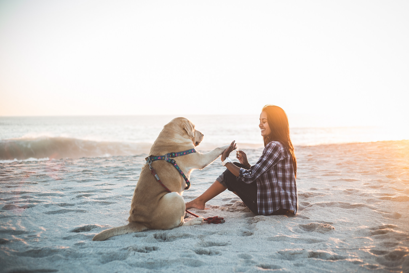

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth


In [13]:
from models.blip import blip_feature_extractor

""" WOnDeRFUL !!!!
    This approach can be useful to detect the presence of a specific object in the image.
    Identified the object, i think that looking into the gradcam we can identify 
    where to locate the filter in the image to detect the object.
"""
image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
    
model = blip_feature_extractor(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

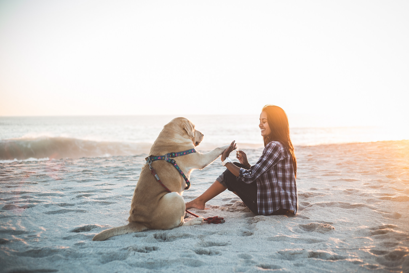

load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth
text: a woman sitting on the beach with a dog
The image and text is matched with a probability of 0.9960
The image feature and text feature has a cosine similarity of 0.5262


In [9]:
from models.blip_itm import blip_itm

""" WOnDeRFUL !!!!

    We can train similar architecture to make the match 
    between the image and the text. -> using CLIP

    Or we can train a simple model to make the match between 
    the catiption of the box and the target label. 
        -> using the same BLIP 1

"""

image_size = 384
image = load_demo_image(image_size=image_size,device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
    
model = blip_itm(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device='cpu')

caption = 'a woman sitting on the beach with a dog'

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)